# State Farm Distracted Driver Detection
## Can computer vision spot distracted drivers?

### Background:
1. Nearly 4,000 people were killed in crashes involving distracted drivers in 2015. Distracted driving was the reported cause of death of 3,450 people in 2016. An estimated 391,000 drivers were injured in distracted driving crashes in 2017 (Motor Vehicle Crash report for 2019)
2. Available camera that could realtime monitoring the driver from distracted

### Approach:
We are going to use CNN to predict different type of distacted diver images. The model will have training and validation processes. 

### Data sources:
Dataset is available from  https://www.kaggle.com/c/state-farm-distracted-driver-detection

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/MyDrive/CapstoneProject/distract_driver/')

## TASK 1: Feature engineering and EDA

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image

import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(tf.__version__)

2.6.0


## Import the Datasets
Import the .csv file to read the labels.

In [4]:
#!unzip state-farm-distracted-driver-detection.zip -d ./data

In [5]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
drv_class = dataset.groupby('classname')
unique_drv = drv_class.groups.keys()
print(unique_drv)

dict_keys(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])


In [7]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

class_def = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the hone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

nb_classes = len(classes)

In [8]:
fig = plt.figure(figsize=(20, 18))
columns = 4
rows = 6
for i in range(1, columns*rows +1):
    pic_idx = random.randint(0, dataset.shape[0])
    im = Image.open('imgs/train/'+ 
                    str(dataset.loc[pic_idx, 'classname']) +'/' 
                    +str(dataset.loc[pic_idx, 'img']))
    fig.add_subplot(rows, columns, i)
    plt.imshow(im)
    plt.title('Driving state: ' + class_def[(dataset.loc[pic_idx, 'classname'])])
    plt.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
# check size of each image 
im = Image.open('imgs/train/c7/img_100702.jpg')
w, h = im.size
print('Size the image is ' + str(im.size))

Size the image is (640, 480)


Normailze the image so that it range from 0 to 1

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [11]:
img_size = (256, 256)
batch_size = 100
train_dir = 'imgs/train/'

train_it = train_datagen.flow_from_directory(train_dir, target_size=img_size, 
                                  color_mode='rgb', batch_size=batch_size,
                                  class_mode='categorical', shuffle=True,
                                  subset='training', seed=42)
val_it = train_datagen.flow_from_directory(train_dir, target_size=img_size, 
                                  color_mode='rgb', batch_size=batch_size,
                                  class_mode='categorical', shuffle=True,
                                  subset='validation', seed=42)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [13]:
for data_batch, labels_batch in train_it:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 256, 256, 3)
labels batch shape: (100, 10)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [ ]:
model.compile('rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### We will use early stopping monitoring on validation loss and model check point saving the model weights

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpointer = ModelCheckpoint(filepath='saved_models/weights_distracted_driver.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)

In [ ]:
nb_epochs = 20

history = model.fit(
train_it,
validation_data=val_it,
epochs=nb_epochs, callbacks=[checkpointer, es])

Epoch 1/20
180/180 [==============================] - 7282s 40s/step - loss: 1.9665 - accuracy: 0.2692 - val_loss: 0.9570 - val_accuracy: 0.6751

Epoch 00001: val_loss improved from inf to 0.95705, saving model to saved_models/weights_distracted_driver.hdf5
Epoch 2/20
180/180 [==============================] - 137s 764ms/step - loss: 0.5310 - accuracy: 0.8220 - val_loss: 0.2271 - val_accuracy: 0.9308

Epoch 00002: val_loss improved from 0.95705 to 0.22706, saving model to saved_models/weights_distracted_driver.hdf5
Epoch 3/20
180/180 [==============================] - 137s 759ms/step - loss: 0.2084 - accuracy: 0.9406 - val_loss: 0.1283 - val_accuracy: 0.9612

Epoch 00003: val_loss improved from 0.22706 to 0.12830, saving model to saved_models/weights_distracted_driver.hdf5
Epoch 4/20
180/180 [==============================] - 136s 756ms/step - loss: 0.1266 - accuracy: 0.9641 - val_loss: 0.1897 - val_accuracy: 0.9560

Epoch 00004: val_loss did not improve from 0.12830
Epoch 5/20
180/180

In [ ]:
model.save('fnl_distracted_driver.h5')

<Figure size 432x288 with 0 Axes>

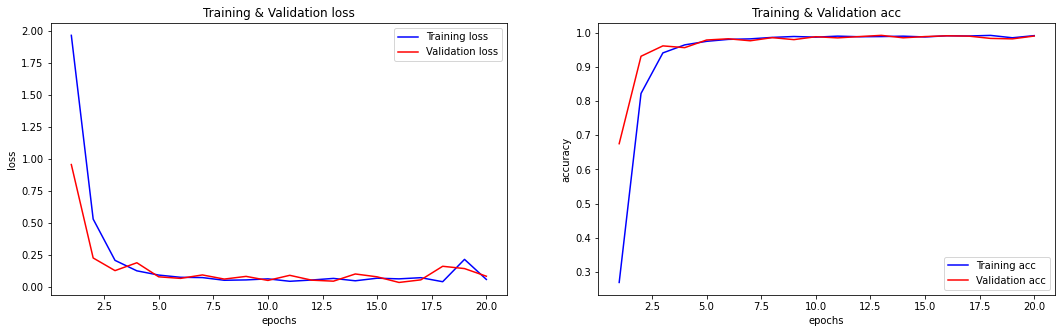

In [ ]:
tr_loss = history.history['loss']
tr_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(tr_loss)+1)

plt.clf()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
fig

ax1.plot(epochs, tr_loss, 'b', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training & Validation loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(epochs, tr_acc, 'b', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training & Validation acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

In [ ]:
# Let's try to predict using the trained model and passing the Validation ImageDataGenerator
# so we can calculate some other metrics (ex.: Top-1, Top-5 accuracy, Confusion Matrix)

# First we need to create a new validation_generator_test without shuffling the data during test time
# We cannot reuse the previous generator because it has shuffle activated by default for training

val_gen_test = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, 
    class_mode='categorical', shuffle=False, subset='validation', seed=42)

Y_pred = model.predict(val_gen_test)

Found 4481 images belonging to 10 classes.


### We then convert the probabilities to a single integer that describes the predicted class 

In [ ]:
Y_pred_comp= np.argmax(Y_pred, axis=1)
print("The Predictions shape is: ", Y_pred_comp.shape)
print("The True Labels shape is: ", val_gen_test.labels.shape)

The Predictions shape is:  (4481,)
The True Labels shape is:  (4481,)


### Confusion matrix were provided to evaluate the model preformance

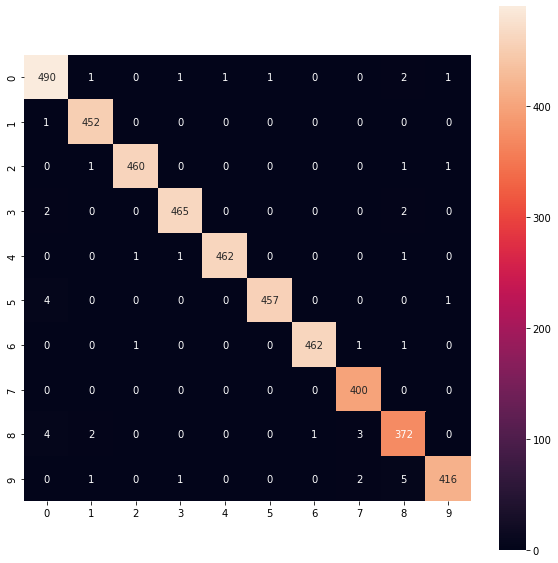

In [ ]:
from sklearn.metrics import confusion_matrix

# Let's calculate the Confusion Matrix for our predictions on the Validation Set
cm = confusion_matrix(val_gen_test.labels, Y_pred_comp)

plt.figure(figsize=(nb_classes,nb_classes))
sns.heatmap(cm, annot=True, fmt='d', square=True)
plt.show()

### We are going to calculate the Top-1 and Top-5 Accuracies but first, we need to convert the labels for the validation DataImageGenerator into One Hot enconding.

In [ ]:
Y_true_one_hot = tf.one_hot(val_gen_test.labels, depth=nb_classes)

# Using Keras TopKCategoricalAccuracy function to Calculate the TOP-1 Accuracy
top1_first_model = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
top1_first_model.update_state(Y_true_one_hot, Y_pred)

# Using Keras TopKCategoricalAccuracy function to Calculate the TOP-5 Accuracy
top5_first_model = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
top5_first_model.update_state(Y_true_one_hot, Y_pred)

print("The First Model Top-1 Accuracy is: ", top1_first_model.result().numpy())
print("The First Model Top-5 Accuracy is: ", top5_first_model.result().numpy())

The First Model Top-1 Accuracy is:  0.9899576
The First Model Top-5 Accuracy is:  0.99910736


### The model can save and load to avoid retraining. This save time for the training procedure. 

In [19]:
# Load saved model, including its weights and the optimizer
model = tf.keras.models.load_model('fnl_distracted_driver.h5')

# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

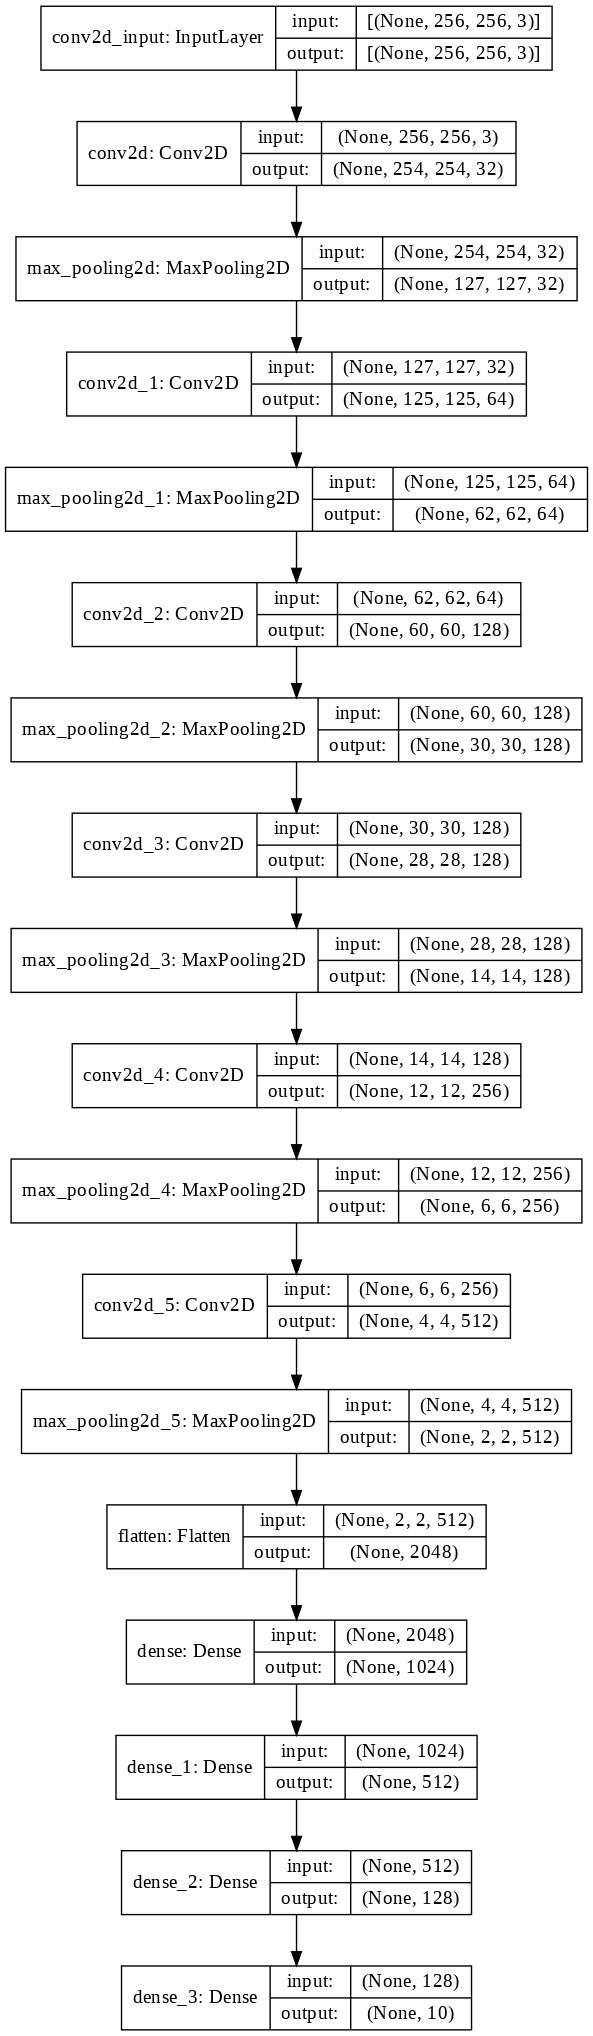

In [64]:
tf.keras.utils.plot_model(model, to_file='DistractDriver1.png', show_shapes=True, 
                          show_layer_names=True,rankdir='TB', dpi=100, expand_nested=True)

In [62]:
# Load the dataset previously downloaded from Kaggle
# Color type: 1 - grey, 3 - rgb

def get_image(path, img_size, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = Image.open(path).convert('L')
    elif color_type == 3:
        img = Image.open(path)
    # Reduce size
    img = np.array(img.resize(img_size)) 
    return img

# Training
def load_train(img_size, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in range(nb_classes):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('..', 'input', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_image(file, img_size[0],img_size[1], color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_size, color_type):
    X, labels = load_train(img_size[0],img_size[1], color_type)
    y = np_utils.to_categorical(labels, nb_classes)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_size[0],img_size[1],color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_size[0],img_size[1],color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_size=[64, 64], color_type=3):
    path = os.path.join('imgs', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in files:
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_image(file, img_size, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_size, color_type=3):
    test_data, test_ids = load_test(size, img_size, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_size[0],img_size[1],color_type)
    
    return test_data, test_ids


def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    #img_brute = cv2.resize(img_brute,(img_size[0],img_size[1]))
    plt.imshow(img_brute)
    new_img =np.expand_dims(img_brute, axis=0)
    y_pred = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_pred))
    key = list(class_def)[np.argmax(y_pred)]
    val = list(class_def.values())[np.argmax(y_pred)]
    plt.title('Driving state: ' + val)
    plt.show()

In [39]:
nb_test_samples = 20
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_size, color_type=3)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

Test shape: (20, 256, 256, 3)
20 Test samples


1/1 [==============================] - 0s 14ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


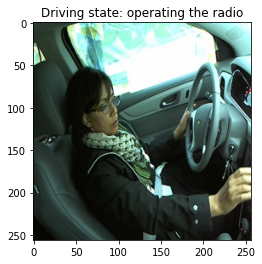

1/1 [==============================] - 0s 12ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


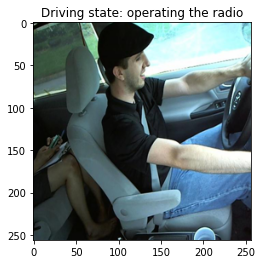

1/1 [==============================] - 0s 14ms/step
Y prediction: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


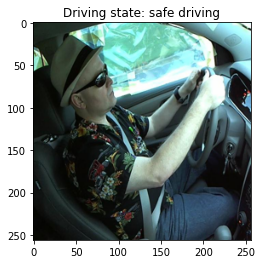

1/1 [==============================] - 0s 13ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


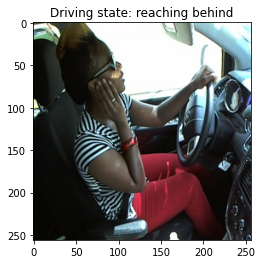

1/1 [==============================] - 0s 13ms/step
Y prediction: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


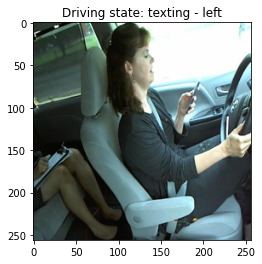

1/1 [==============================] - 0s 16ms/step
Y prediction: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


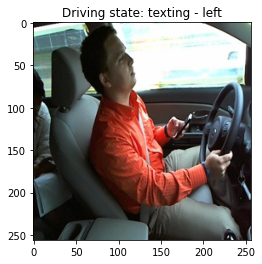

1/1 [==============================] - 0s 13ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


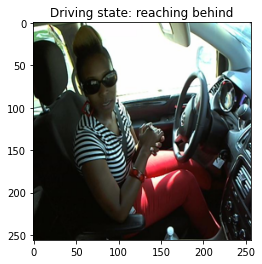

1/1 [==============================] - 0s 12ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


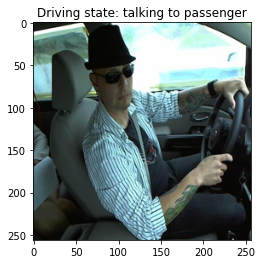

1/1 [==============================] - 0s 12ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


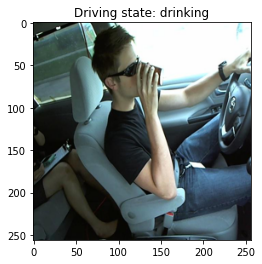

1/1 [==============================] - 0s 12ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


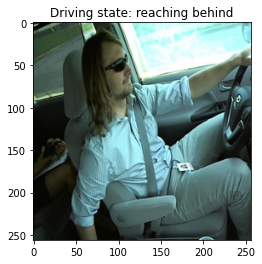

In [63]:
for i in range(10):
 plot_test_class(model, test_files, i) 